## Homework Reflection 9

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

### Heteroskedasticity Simulation

True coefficient: 2.5000
OLS estimate: 2.4882
True SE (from full simulation): 0.0391
OLS SE (assumes homoskedasticity): 0.0350
Bootstrap SE: 0.0390


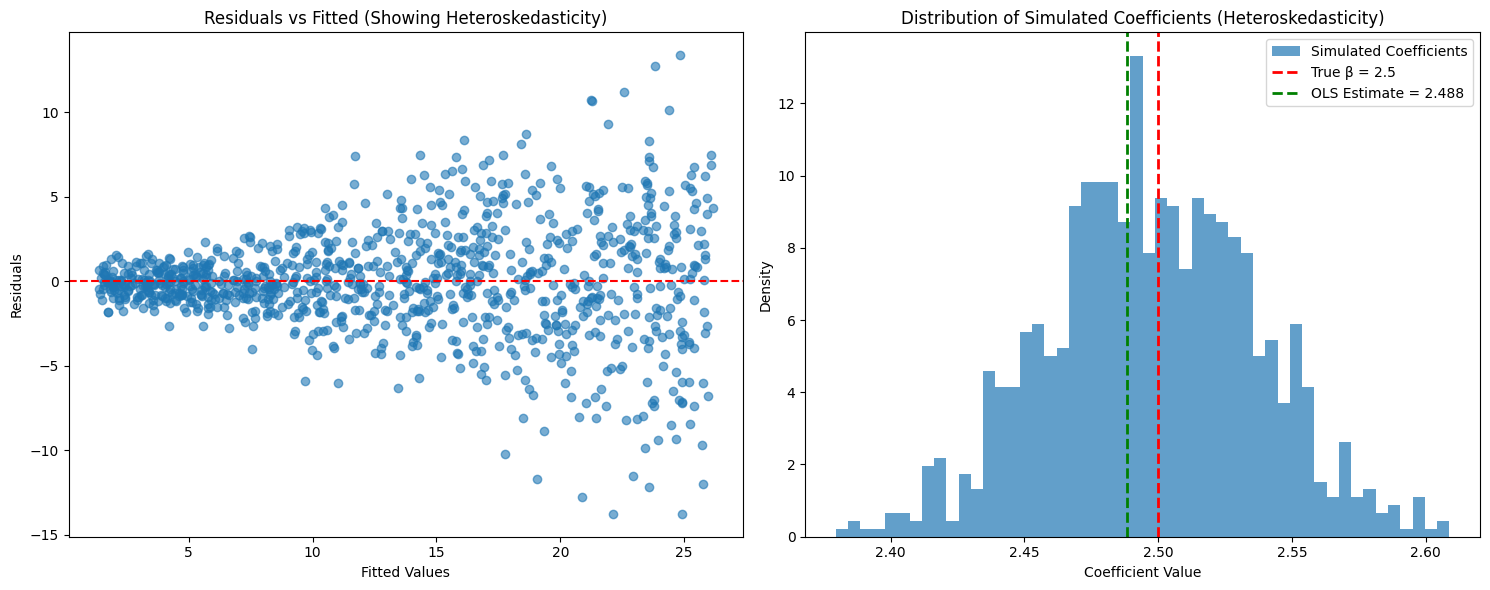

In [6]:
# Generate data with heteroskedasticity where error variance increases with X
def generate_heteroskedastic_data(n=1000, beta_true=2.5):
    X = np.random.uniform(0, 10, n)
    # Error variance increases with X (heteroskedasticity)
    error_variance = 0.5 + 0.3 * X**2
    errors = np.random.normal(0, np.sqrt(error_variance))
    y = 1.0 + beta_true * X + errors
    return X, y, beta_true

# Run multiple simulations to estimate true standard deviation of coefficient
def simulate_heteroskedastic_coefficients(n_simulations=1000, sample_size=1000):
    coefficients = []
    
    for _ in range(n_simulations):
        X, y, _ = generate_heteroskedastic_data(sample_size)
        X_with_const = sm.add_constant(X)
        model = sm.OLS(y, X_with_const).fit()
        coefficients.append(model.params[1])  # Slope coefficient
    
    return np.array(coefficients)

# Bootstrap estimation of standard error
def bootstrap_heteroskedastic_se(X, y, n_bootstrap=1000):
    n = len(X)
    bootstrap_coefs = []
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = resample(range(n), n_samples=n, random_state=None)
        X_boot = X[indices]
        y_boot = y[indices]
        
        # Fit model
        X_boot_const = sm.add_constant(X_boot)
        model = sm.OLS(y_boot, X_boot_const).fit()
        bootstrap_coefs.append(model.params[1])
    
    return np.std(bootstrap_coefs)

# Generate one dataset for comparison
X, y, beta_true = generate_heteroskedastic_data(1000)
X_const = sm.add_constant(X)

# Fit OLS model
ols_model = sm.OLS(y, X_const).fit()
ols_se = ols_model.bse[1]  # Standard error from OLS
ols_coef = ols_model.params[1]

# Run full simulation to get true standard deviation
sim_coefficients = simulate_heteroskedastic_coefficients(1000, 1000)
true_se = np.std(sim_coefficients)

# Bootstrap standard error
bootstrap_se = bootstrap_heteroskedastic_se(X, y, 1000)

print(f"True coefficient: {beta_true:.4f}")
print(f"OLS estimate: {ols_coef:.4f}")
print(f"True SE (from full simulation): {true_se:.4f}")
print(f"OLS SE (assumes homoskedasticity): {ols_se:.4f}")
print(f"Bootstrap SE: {bootstrap_se:.4f}")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Residuals vs fitted to show heteroskedasticity
fitted = ols_model.fittedvalues
residuals = ols_model.resid
ax1.scatter(fitted, residuals, alpha=0.6)
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Fitted (Showing Heteroskedasticity)')
ax1.axhline(y=0, color='r', linestyle='--')

# Plot 2: Distribution of simulated coefficients
ax2.hist(sim_coefficients, bins=50, alpha=0.7, density=True, label='Simulated Coefficients')
ax2.axvline(beta_true, color='red', linestyle='--', linewidth=2, label=f'True β = {beta_true}')
ax2.axvline(ols_coef, color='green', linestyle='--', linewidth=2, label=f'OLS Estimate = {ols_coef:.3f}')
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of Simulated Coefficients (Heteroskedasticity)')
ax2.legend()

plt.tight_layout()
plt.show()

### Correlated Errors Simulation

In [8]:
# Generate data with highly correlated errors (AR(1) process)
def generate_correlated_errors_data(n=1000, beta_true=1.5, correlation=0.8):
    X = np.random.uniform(0, 5, n)
    
    # Generate AR(1) correlated errors
    errors = np.zeros(n)
    errors[0] = np.random.normal(0, 1)
    
    for i in range(1, n):
        errors[i] = correlation * errors[i-1] + np.random.normal(0, np.sqrt(1 - correlation**2))
    
    y = 2.0 + beta_true * X + errors
    return X, y, beta_true

# Run multiple simulations with correlated errors
def simulate_correlated_coefficients(n_simulations=1000, sample_size=1000, correlation=0.8):
    coefficients = []
    
    for _ in range(n_simulations):
        X, y, _ = generate_correlated_errors_data(sample_size, correlation=correlation)
        X_with_const = sm.add_constant(X)
        model = sm.OLS(y, X_with_const).fit()
        coefficients.append(model.params[1])
    
    return np.array(coefficients)

# Bootstrap estimation with correlated errors
def bootstrap_correlated_se(X, y, n_bootstrap=1000):
    n = len(X)
    bootstrap_coefs = []
    
    for _ in range(n_bootstrap):
        # Block bootstrap to preserve correlation structure
        block_size = min(50, n // 10)  # Use block bootstrap
        n_blocks = n // block_size
        
        bootstrap_indices = []
        for _ in range(n_blocks + 1):
            start_idx = np.random.randint(0, n - block_size + 1)
            bootstrap_indices.extend(range(start_idx, min(start_idx + block_size, n)))
        
        bootstrap_indices = bootstrap_indices[:n]  # Trim to exact size
        
        X_boot = X[bootstrap_indices]
        y_boot = y[bootstrap_indices]
        
        X_boot_const = sm.add_constant(X_boot)
        model = sm.OLS(y_boot, X_boot_const).fit()
        bootstrap_coefs.append(model.params[1])
    
    return np.std(bootstrap_coefs)

# Test with different correlation levels
correlations = [0.3, 0.6, 0.9]
results = []

print("Comparing Standard Errors under Different Correlation Levels:")
print("Correlation | True SE | OLS SE | Bootstrap SE | SE Ratio (Bootstrap/True)")
print("-" * 75)

for corr in correlations:
    # Generate data
    X, y, beta_true = generate_correlated_errors_data(1000, correlation=corr)
    X_const = sm.add_constant(X)
    
    # OLS fit
    ols_model = sm.OLS(y, X_const).fit()
    ols_se = ols_model.bse[1]
    
    # True SE from simulation
    sim_coefficients = simulate_correlated_coefficients(500, 1000, corr)
    true_se = np.std(sim_coefficients)
    
    # Bootstrap SE
    bootstrap_se = bootstrap_correlated_se(X, y, 500)
    
    se_ratio = bootstrap_se / true_se
    
    print(f"{corr:>11.1f} | {true_se:>7.4f} | {ols_se:>6.4f} | {bootstrap_se:>12.4f} | {se_ratio:>18.3f}")
    
    results.append({
        'correlation': corr,
        'true_se': true_se,
        'ols_se': ols_se,
        'bootstrap_se': bootstrap_se,
        'coefficients': sim_coefficients
    })

Comparing Standard Errors under Different Correlation Levels:
Correlation | True SE | OLS SE | Bootstrap SE | SE Ratio (Bootstrap/True)
---------------------------------------------------------------------------
        0.3 |  0.0210 | 0.0225 |       0.0164 |              0.783
        0.6 |  0.0221 | 0.0212 |       0.0243 |              1.103
        0.9 |  0.0215 | 0.0231 |       0.0190 |              0.886


### Bootstrap Failure With High Correlation

True SE from full simulation: 0.0297

Bootstrap Results with Different Bootstrap Sample Sizes:
Bootstrap Size | Bootstrap SE | Ratio to True SE
---------------------------------------------
          100 |      0.0235 |           0.792
          500 |      0.0222 |           0.748
         1000 |      0.0223 |           0.753
         2000 |      0.0224 |           0.753


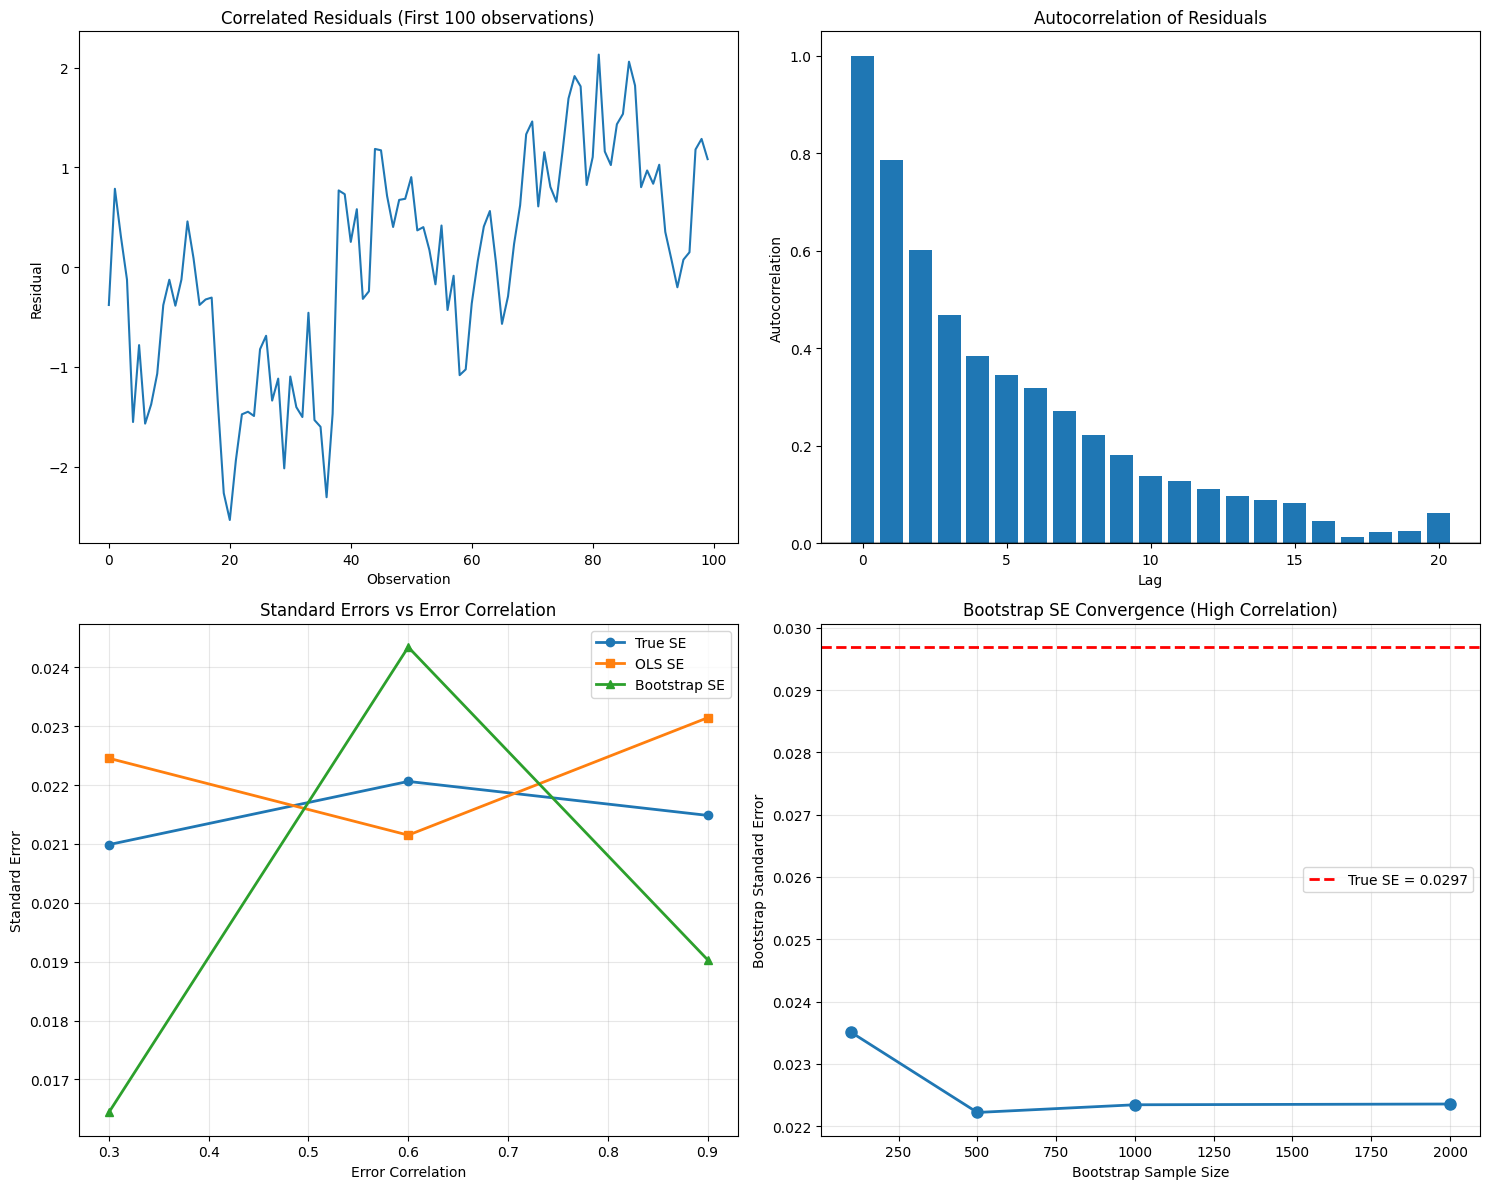

In [9]:
# Generate data with very high correlation
X, y, beta_true = generate_correlated_errors_data(500, correlation=0.95)  # Smaller sample

# Compare bootstrap with different sample sizes
bootstrap_sizes = [100, 500, 1000, 2000]
true_coefficients = simulate_correlated_coefficients(1000, 500, 0.95)
true_se = np.std(true_coefficients)

print(f"True SE from full simulation: {true_se:.4f}")
print("\nBootstrap Results with Different Bootstrap Sample Sizes:")
print("Bootstrap Size | Bootstrap SE | Ratio to True SE")
print("-" * 45)

bootstrap_results = []
for boot_size in bootstrap_sizes:
    boot_se = bootstrap_correlated_se(X, y, boot_size)
    ratio = boot_se / true_se
    print(f"{boot_size:>13} | {boot_se:>11.4f} | {ratio:>15.3f}")
    bootstrap_results.append(boot_se)

# Final visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Correlated errors time series
X_demo, y_demo, _ = generate_correlated_errors_data(200, correlation=0.8)
X_const_demo = sm.add_constant(X_demo)
model_demo = sm.OLS(y_demo, X_const_demo).fit()
residuals_demo = model_demo.resid

ax1.plot(residuals_demo[:100])
ax1.set_title('Correlated Residuals (First 100 observations)')
ax1.set_xlabel('Observation')
ax1.set_ylabel('Residual')

# Plot 2: Autocorrelation of residuals
from statsmodels.tsa.stattools import acf
autocorr = acf(residuals_demo, nlags=20)
ax2.bar(range(len(autocorr)), autocorr)
ax2.set_title('Autocorrelation of Residuals')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Plot 3: SE comparison across correlations
corr_vals = [r['correlation'] for r in results]
true_ses = [r['true_se'] for r in results]
ols_ses = [r['ols_se'] for r in results]
boot_ses = [r['bootstrap_se'] for r in results]

ax3.plot(corr_vals, true_ses, 'o-', label='True SE', linewidth=2)
ax3.plot(corr_vals, ols_ses, 's-', label='OLS SE', linewidth=2)
ax3.plot(corr_vals, boot_ses, '^-', label='Bootstrap SE', linewidth=2)
ax3.set_xlabel('Error Correlation')
ax3.set_ylabel('Standard Error')
ax3.set_title('Standard Errors vs Error Correlation')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Bootstrap convergence
ax4.plot(bootstrap_sizes, bootstrap_results, 'o-', linewidth=2, markersize=8)
ax4.axhline(y=true_se, color='red', linestyle='--', linewidth=2, label=f'True SE = {true_se:.4f}')
ax4.set_xlabel('Bootstrap Sample Size')
ax4.set_ylabel('Bootstrap Standard Error')
ax4.set_title('Bootstrap SE Convergence (High Correlation)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()